<a href="https://colab.research.google.com/github/MN1973/DataScienceProject/blob/main/GurusQn_Classification_LSTM_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv2D, Flatten, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
import nltk
import re
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from imblearn.over_sampling import SMOTE



In [ ]:
# Load the CSV file
df=pd.read_csv(r"/content/drive/MyDrive/Gurus_URLs.csv")

In [ ]:
df.head()

,Srno,url,total_impressions,total_clicks,expected_clicks,url_score,qno,Text,Label
0,1,https://gurus.rediff.com/question/question-det...,"44,751","1,926",228,8.43,5139076,My wife is having illegit sexual relationship ...,1
1,2,https://gurus.rediff.com/question/question-det...,"53,917",824,179,4.60,5137231,Recently my elder brother has expired. His wif...,1
2,3,https://gurus.rediff.com/question/question-det...,"251,863","5,208","1,181",4.41,5143452,I am 64 and my wife 60 yrs of age . I want fre...,1
3,4,https://gurus.rediff.com/question/question-det...,"184,427","3,702",886,4.18,5143494,I have a GF who wanted to get intimate with me...,1
4,5,https://gurus.rediff.com/question/question-det...,"17,175",311,75,4.15,5137979,"Hi Anu \n\nI am 52 , I am in a relationship wi...",1


In [ ]:
#Truncate the sentences at 55 characters
max_length = 55

def truncate_text(text):
    if len(text) <= max_length:
        return text
    else:
        # Find the closest word boundary before max_length
        truncated_text = text[:max_length]
        last_space_index = truncated_text.rfind(' ')
        if last_space_index != -1:
            return truncated_text[:last_space_index]
        else:
            return ''

# Apply the truncate_text function to the "Text" column
df['Text'] = df['Text'].apply(truncate_text)

In [ ]:
#Download the NLTK words corpus (a list of standard English words)
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')

# Define a function to clean text
def clean_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Define a regular expression pattern to match alphanumeric characters and spaces
    pattern = re.compile(r'[\w\s]+')

    # Filter words using the pattern
    clean_words = [word for word in words if pattern.match(word)]

    # Join the clean words back into a string
    cleaned_text = ' '.join(clean_words)

    return cleaned_text

# Apply the clean_text function to the 'cleaned_column' and create a new column 'cleaned_text'
df['cleaned_text'] = df['Text'].apply(clean_text)



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(df['cleaned_text'])

0       My wife is having illegit sexual relationship ...
1       Recently my elder brother has expired His wife...
2       I am 64 and my wife 60 yrs of age I want frequent
3       I have a GF who wanted to get intimate with me...
4        Hi Anu I am 52 I am in a relationship with a man
                              ...                        
4307    Hellow sir Request you to please suggest and h...
4308    why there is no LIquitidy and openness in RITE...
4309    Can A level student appearing in May June seri...
4310    How tu improve marks in bio mera syllabus max ...
4311         Hi I had complete my Higher Secondary School
Name: cleaned_text, Length: 4312, dtype: object


In [ ]:
def preprocess_text(cleaned_text):
    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(cleaned_text)

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    # Initialize a Snowball stemmer
    stemmer = SnowballStemmer('english')

    # Stem the words
    words = [stemmer.stem(word) for word in words]

    # Join the preprocessed words back into a string
    processed_text = ' '.join(words)

    return processed_text

In [ ]:
df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text)

In [ ]:
# Tokenize the text data
max_words = 5070

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit the tokenizer on the list of sentences
tokenizer.fit_on_texts(df['cleaned_text'])

X = tokenizer.texts_to_sequences(df['cleaned_text'])

In [ ]:
max_words = len(tokenizer.word_index) + 1

In [ ]:
max_length = 10
X = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

In [ ]:
y = df['Label'].values

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [ ]:
print(vocab_size)

4322


In [ ]:
# Apply SMOTE to oversample the minority class
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=42)

In [ ]:
# For X_train
num_zeros_train = np.count_nonzero(y_train == 0)
num_ones_train = np.count_nonzero(y_train == 1)

# For X_val
num_zeros_val = np.count_nonzero(y_val == 0)
num_ones_val = np.count_nonzero(y_val == 1)

print("Number of 0s in y_train:", num_zeros_train)
print("Number of 1s in y_train:", num_ones_train)
print("Number of 0s in y_val:", num_zeros_val)
print("Number of 1s in y_val:", num_ones_val)

Number of 0s in y_train: 2543
Number of 1s in y_train: 2495
Number of 0s in y_val: 606
Number of 1s in y_val: 654


In [ ]:
# Create and train a Word2Vec model on your data
from gensim.models import Word2Vec

embedding_dim = 100
Gurus_word2vec_model = Word2Vec(df['cleaned_text'], vector_size=embedding_dim, window=5, min_count=1, sg=0, workers=4)

In [ ]:
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    if word in Gurus_word2vec_model.wv:
        embedding_matrix[i] = Gurus_word2vec_model.wv[word]

In [ ]:
word_embeddings = {}
for word in Gurus_word2vec_model.wv.index_to_key:
    word_embeddings[word] = Gurus_word2vec_model.wv[word]

In [ ]:
def f1_score_metric(y_val, y_pred):
    y_val = tf.cast(y_val, tf.float32)  # Ensure y_true has the same data type as y_pred
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_val * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_val, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_score

In [ ]:
def buildmodel(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))

    # Sample the number of LSTM units from the hyperparameter search space
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(LSTM(units=lstm_units))

    # Sample the number of units for the Dense layer
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=32)
    model.add(Dense(units=dense_units, activation='relu'))

    # Sample the dropout rate from the hyperparameter search space
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))

    # Set the optimizer with the specified learning rate
    optimizer = Adam(learning_rate=0.001)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_score_metric])
    return model




In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

Using TensorFlow backend


<ipython-input-26-5fd8096cdee5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# Create the Keras Tuner instance
tuner = kt.RandomSearch(
    buildmodel,
    objective=kt.Objective('f1_score_metric', direction='max'),
    max_trials=10,
    directory='my_tuner_directory',
    project_name='my_text_classification_tuner'
)

In [ ]:
# Define the search space for hyperparameters
tuner.search_space_summary()


Search space summary
Default search space size: 3
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [ ]:
# Perform hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=200, verbose=0)

Final Model

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Get all best hyperparameters and their values
best_hyperparameters = []
for trial in tuner.oracle.get_best_trials(10):  # Replace '10' with the number of best trials you want to retrieve
    hyperparameters = trial.hyperparameters.values
    best_hyperparameters.append(hyperparameters)

# Print the list of best hyperparameters and their values
for idx, hyperparameters in enumerate(best_hyperparameters, start=1):
    print(f"Best Hyperparameters - Trial {idx}:")
    for param_name, param_value in hyperparameters.items():
        print(f"{param_name}: {param_value}")
    print("\n")


Best Hyperparameters - Trial 1:
lstm_units: 64
dense_units: 224
dropout_rate: 0.30000000000000004


Best Hyperparameters - Trial 2:
lstm_units: 256
dense_units: 224
dropout_rate: 0.2


Best Hyperparameters - Trial 3:
lstm_units: 128
dense_units: 64
dropout_rate: 0.4


Best Hyperparameters - Trial 4:
lstm_units: 256
dense_units: 192
dropout_rate: 0.4


Best Hyperparameters - Trial 5:
lstm_units: 96
dense_units: 224
dropout_rate: 0.2


Best Hyperparameters - Trial 6:
lstm_units: 192
dense_units: 256
dropout_rate: 0.4


Best Hyperparameters - Trial 7:
lstm_units: 224
dense_units: 64
dropout_rate: 0.4


Best Hyperparameters - Trial 8:
lstm_units: 64
dense_units: 96
dropout_rate: 0.4


Best Hyperparameters - Trial 9:
lstm_units: 192
dense_units: 128
dropout_rate: 0.4


Best Hyperparameters - Trial 10:
lstm_units: 128
dense_units: 256
dropout_rate: 0.30000000000000004




In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps)

Best Hyperparameters:


In [ ]:
# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Train the final model on your training data
final_model.fit(X_train, y_train, epochs=100, batch_size=200, validation_data=(X_val, y_val))

# Predict on the validation data
y_pred = final_model.predict(X_val)

# Calculate F1 score for the current weight combination
f1 = f1_score(y_val, (y_pred > 0.5).astype(int))  # Assuming binary classification, adjust the threshold as needed

Epoch 1/100
26/26 [==============================] - 3s 36ms/step - loss: 0.6891 - f1_score_metric: 0.3305 - val_loss: 0.6942 - val_f1_score_metric: 0.2567
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6842 - f1_score_metric: 0.2843 - val_loss: 0.6927 - val_f1_score_metric: 0.2512
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6831 - f1_score_metric: 0.2764 - val_loss: 0.6895 - val_f1_score_metric: 0.2567
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6832 - f1_score_metric: 0.2828 - val_loss: 0.6887 - val_f1_score_metric: 0.2515
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6822 - f1_score_metric: 0.2785 - val_loss: 0.6892 - val_f1_score_metric: 0.2532
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6822 - f1_score_metric: 0.3000 - val_loss: 0.6884 - val_f1_score_metric: 0.2438
Epoch 7/100
26/26 [==============================] - 1s 23ms/ste

In [ ]:
# Save the entire model (architecture and weights) to a file
final_model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = (final_model.predict(X_val) > 0.1).astype(int)
confusion = confusion_matrix(y_val, y_pred)


40/40 [==============================] - 0s 4ms/step


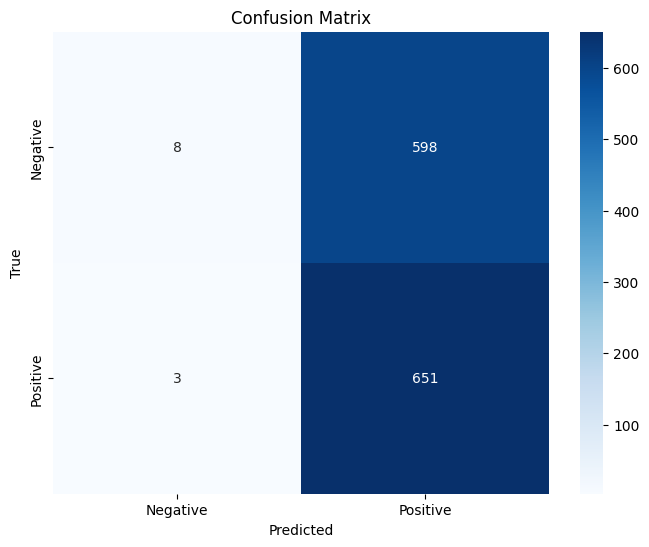

In [ ]:
# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_val, y_pred, target_names=["Will not click", "Will click"])

# Print the classification report
print(report)

                precision    recall  f1-score   support

Will not click       0.73      0.01      0.03       606
    Will click       0.52      1.00      0.68       654

      accuracy                           0.52      1260
     macro avg       0.62      0.50      0.36      1260
  weighted avg       0.62      0.52      0.37      1260



In [ ]:
# Make predictions on a new sentence
new_sentence = "I want to run briyani business from home kitchen .... "
new_sequence = tokenizer.texts_to_sequences([new_sentence])
new_sequence = pad_sequences(new_sequence, maxlen=max_length)
prediction = final_model.predict(new_sequence)
predicted_class = np.argmax(prediction)

output_class = {0: 'wont click', 1: 'will click'}
print(f"Users {output_class[predicted_class]} the question '{new_sentence}'")



1/1 [==============================] - 0s 19ms/step
Users wont click the question 'I want to run briyani business from home kitchen .... '
